<a href="https://colab.research.google.com/github/Juanes1793/Proyectos-Data-Science/blob/main/Google_Colabs/Time_Series/Stacked_LSTM_Secuence_to_Secuence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STACKED LSTM SECUENCE TO SECUENCE

Se pueden "stackear" (juntar) varias capas LSTM ocultas una encima de otra en lo que se conoce como modelo STACKED LSTM.

Una capa LSTM requiere una entrada tridimensional y los LSTM por defecto producirán una salida bidimensional como una interpretación del final de la secuencia.

Podemos abordar esto haciendo que el LSTM genere un valor para cada paso de tiempo en los datos de entrada configurando el argumento return_sequences=True en la capa. Esto nos permite tener una salida 3D de la capa LSTM oculta como entrada para la siguiente.

Por lo tanto, podemos definir una STACKED LSTM de la siguiente manera.



<img src = "https://www.researchgate.net/publication/350105975/figure/fig3/AS:1002223085559809@1615960012219/Two-layered-stacked-LSTM-network.png">

### Se importan las librerías

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import datetime


### Se lee el dataSet

In [2]:
url = "https://raw.githubusercontent.com/Juanes1793/Proyectos-Data-Science/main/Base_datos/DemandCharge.csv"
#df = pd.read_csv("DemandCharge.csv")
df = pd.read_csv(url)

In [3]:
df_2 = df.copy()
df_2.rename(columns = {'TotalCampusLoad':'Demanda_Campus'}, inplace = True)
df_2['DateTime'] = pd.to_datetime(df_2.DateTime)
df_2.sort_values(by=['DateTime'], axis=0, ascending=True, inplace=True)
df_2.reset_index(inplace=True, drop=True)
df_2 = df_2.set_index('DateTime')


In [4]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Se programa una función sequence to sequence que servirá como ventana o sliding window para nuestra serie de tiempo

In [5]:
Demanda = df_2["Demanda_Campus"]																# Se obtiene una sola columna del dataFrame que será a la que se le hace la predicción.
demanda_lista = df_2["Demanda_Campus"].tolist()									# Se convierte la columna del dataFrame a lista

# choose a number of time steps

n_steps_in, n_steps_out = 96, 1																# Se usa 96 porque es el número de datos por día que se obtienen cada 15 minutos de la microrred

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [6]:
X, y = split_sequence(demanda_lista,n_steps_in,n_steps_out)                # Se aplica la función teniendo en cuenta los datos de la demanda y el número de pasos, en este caso 96

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X) 
y = y.reshape(-1,1)
y_scaled = scaler.fit_transform(y) 

n_features = 1                                              # Se asigna 1 porque estamos trabajando con una serie univariada
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], n_features))         # Se redimensiona el arreglo dependiendo del número de características de este y condiciones iniciales
y_scaled = y_scaled.reshape((y_scaled.shape[0], y_scaled.shape[1], n_features)) 

Se reparten los datos en entrenamiento y prueba. 80% para prueba y 20% para entrenamiento



In [7]:
X_train,y_train = X_scaled[:60598],y_scaled[:60598]                        # Datos de entrenamiento
X_test,y_test = X_scaled[60598:],y_scaled[60598:]                          # Datos de prueba



Se define el modelo

In [8]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu',return_sequences=True))  #Línea de código adicional 
model.add(LSTM(100, activation='relu',return_sequences=True))  #Línea de código adicional
model.add(TimeDistributed(Dense(1)))
#model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam', loss='mean_absolute_error')

In [9]:
history = model.fit(X_train,y_train, validation_split = 0.1, epochs=20)    

Epoch 1/20
1705/1705 [==============================] - 130s 74ms/step - loss: 21865.5625 - val_loss: 17.0809
Epoch 2/20
1705/1705 [==============================] - 124s 73ms/step - loss: 6.6113 - val_loss: 802.5472
Epoch 3/20
1705/1705 [==============================] - 124s 72ms/step - loss: 76.5471 - val_loss: 0.1632
Epoch 4/20
1705/1705 [==============================] - 123s 72ms/step - loss: 181.3157 - val_loss: 0.1508
Epoch 5/20
1705/1705 [==============================] - 124s 73ms/step - loss: 20.1616 - val_loss: 0.1558
Epoch 6/20
1705/1705 [==============================] - 123s 72ms/step - loss: 0.2336 - val_loss: 0.1530
Epoch 7/20
1705/1705 [==============================] - 121s 71ms/step - loss: 0.0963 - val_loss: 0.1673
Epoch 8/20
1705/1705 [==============================] - 123s 72ms/step - loss: 0.0954 - val_loss: 0.1437
Epoch 9/20
1705/1705 [==============================] - 122s 72ms/step - loss: 0.0958 - val_loss: 0.1535
Epoch 10/20
1705/1705 [=====================

In [10]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


### Gráfica de comparación de model loss

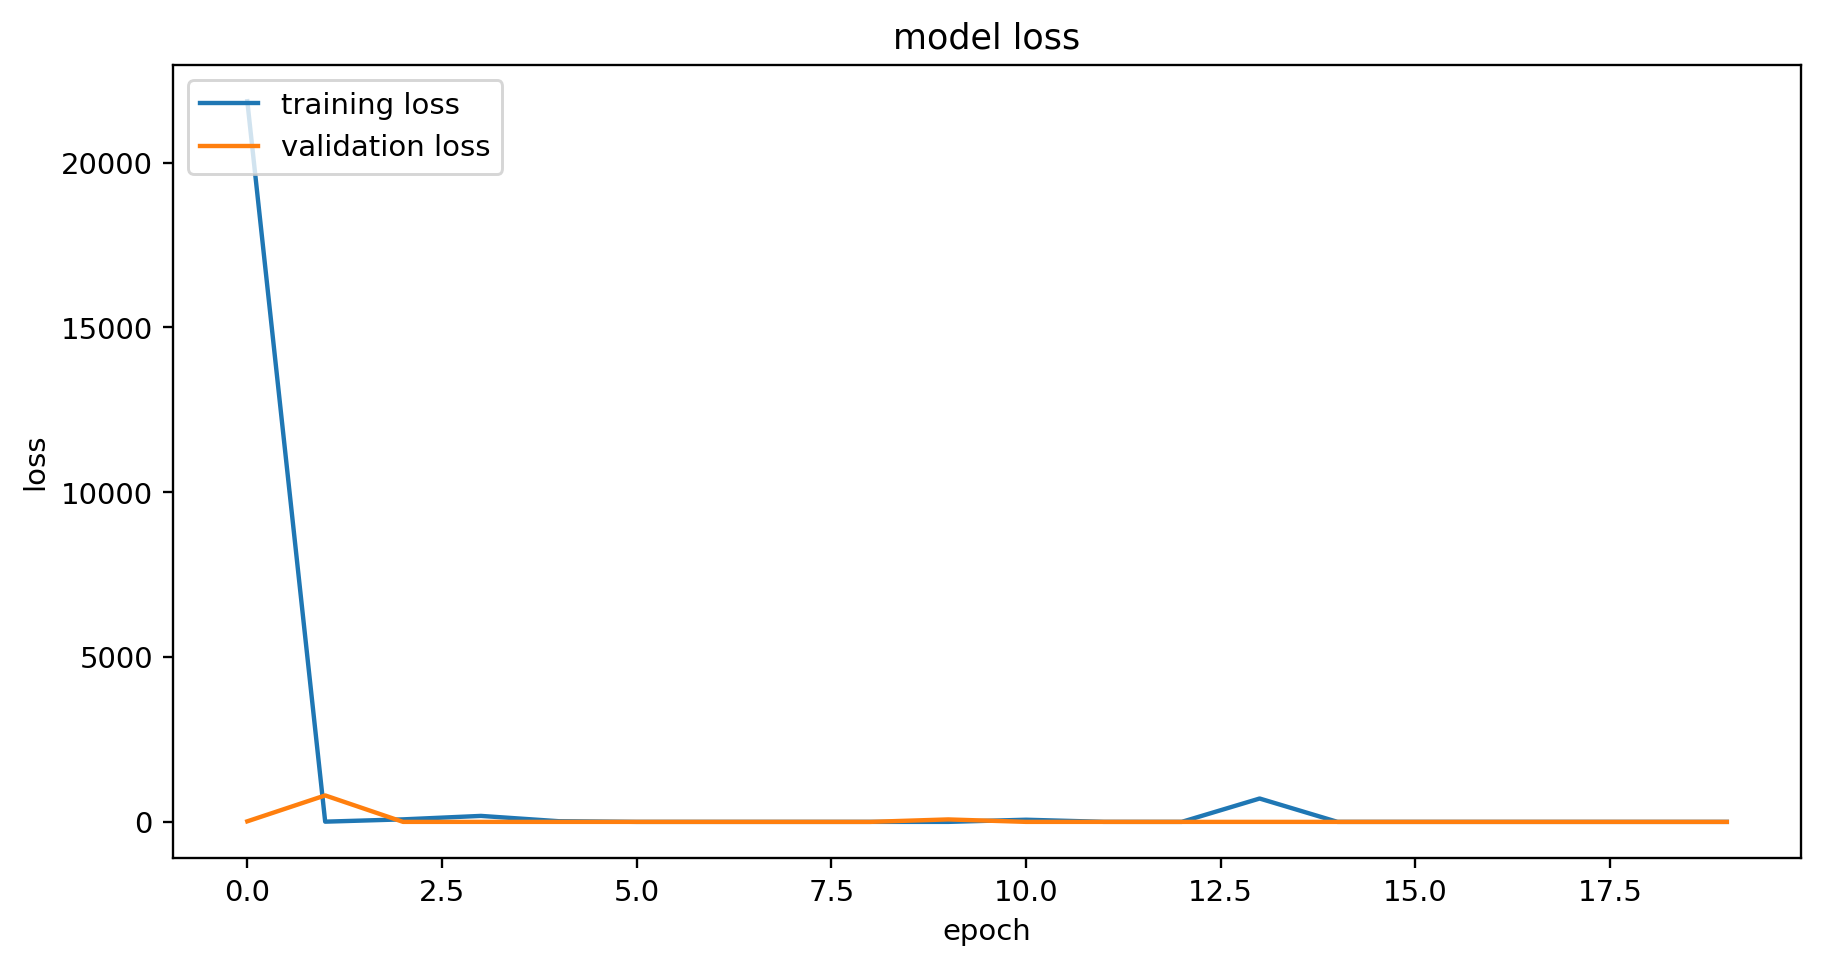

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

### Se organizan los datos para organizarse en un dataFrame

In [12]:
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)                        # Se realizan las predicciones
#print(yhat)

# Importanción de librería 
from functools import reduce
Lista_predict = yhat.tolist()                                  # Se transforma el array en una nested list (lista dentro de listas) 
prediccion = reduce(lambda x,y: x+y, Lista_predict)            # Luego se transforma en una lista de una sola dimensión          


y_test = y_test.tolist()                                       # Se transforma el array en una nested list (lista dentro de listas) 
y_test1 = reduce(lambda x,y: x+y, y_test)                      # Se transforma el array en una nested list (lista dentro de listas)  

### Se escalan los datos a su valor real 

In [13]:
#Se vuelven a escalar los datos a su valor real para los datos de prueba
ytest_real = scaler.inverse_transform(y_test1)
ytest_real = ytest_real.tolist()
ytest_real1 = reduce(lambda x,y: x+y, ytest_real)  

#Se vuelven a escalar los datos a su valor real para las predicciones

yreal_prediccion = scaler.inverse_transform(prediccion) 
yreal_prediccion = yreal_prediccion.tolist()
yreal_prediccion1 = reduce(lambda x,y: x+y, yreal_prediccion)   

### Se muestran los datos comparados en un dataframe y en una gráfica con sus valores reales

In [14]:
# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame 


train_results = pd.DataFrame(data={'Train Predictions':yreal_prediccion1 , 'Actuals':ytest_real1})
train_results

,Train Predictions,Actuals
0,37713.460041,38044.49
1,37839.048429,38031.04
2,37920.288183,38453.51
3,38151.079886,39728.97
4,38853.883125,39681.40
...,...,...
15145,31278.551630,31552.81
15146,31322.613319,31364.09
15147,31281.731795,31236.65
15148,31211.775717,31096.75


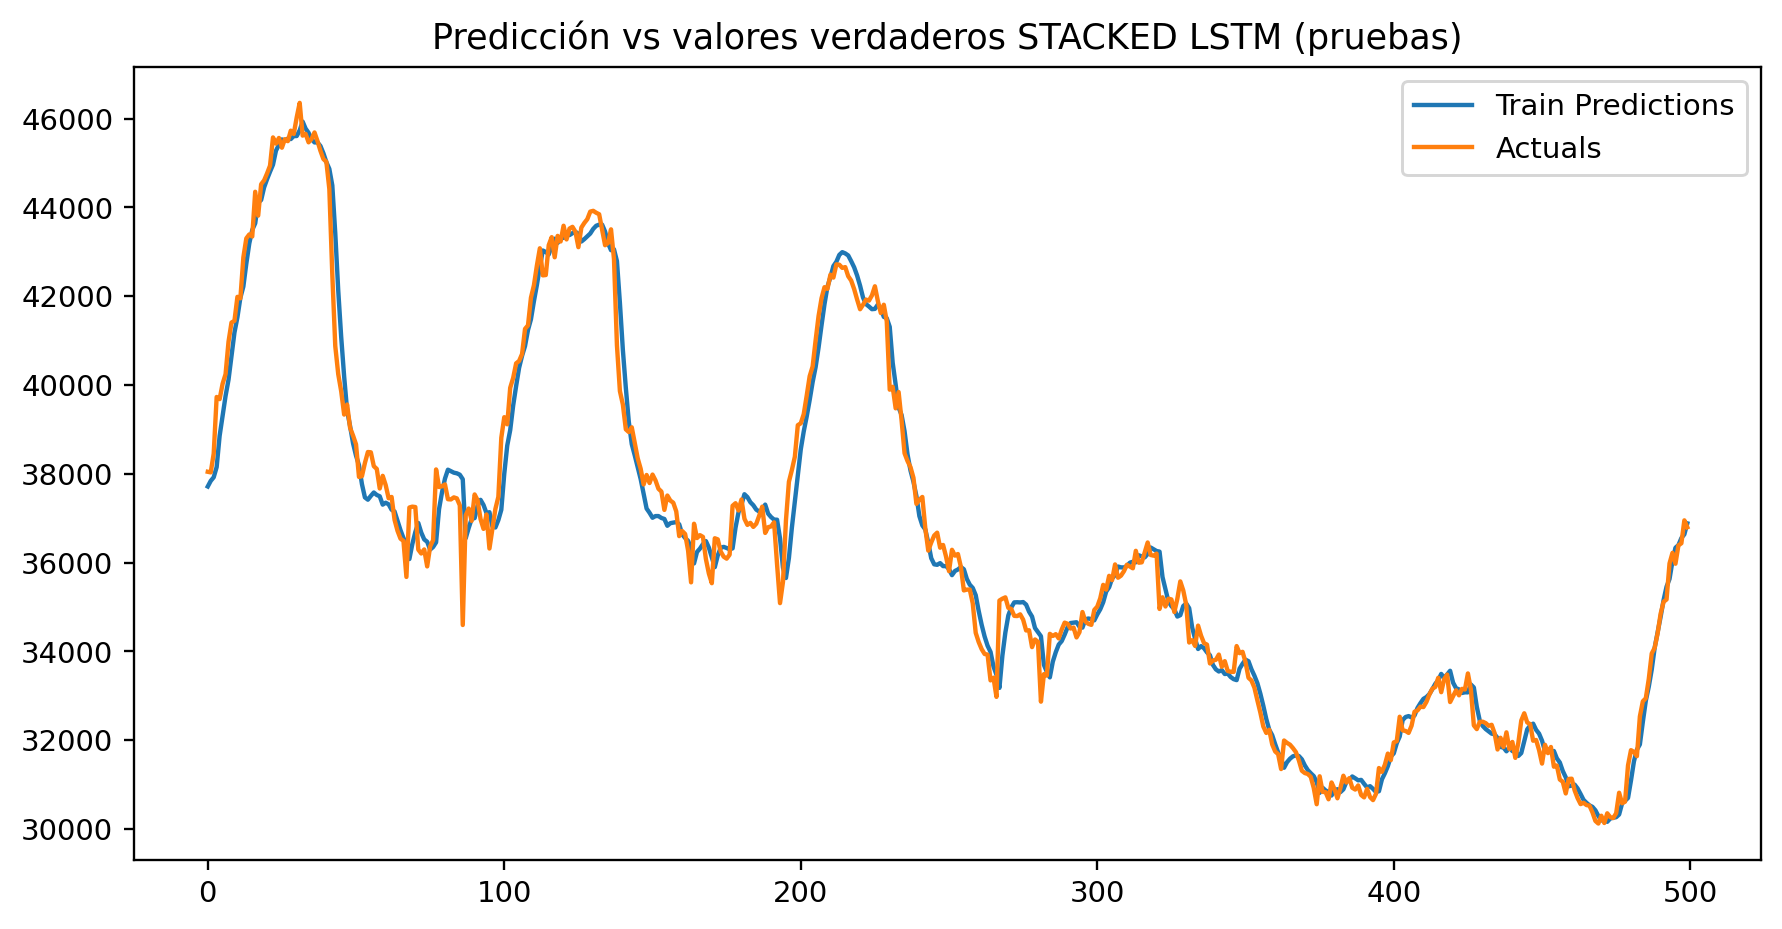

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)
plt.plot(train_results["Train Predictions"][:500],label="Train Predictions")
plt.plot(train_results["Actuals"][:500],label="Actuals")
plt.title("Predicción vs valores verdaderos STACKED LSTM (pruebas)")
plt.legend();

### Métricas de medición

In [16]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
# Métricas de rendimiento
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error #Error absoluto, cuadrado, y cuadrado logarítmico.



print(f"Test Mean Squared Error: {mean_squared_error(y_test1, prediccion)}")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test1, prediccion)}")
print(f"Test Mean squared log error: {mean_squared_log_error(y_test1, prediccion)}")
mape = mean_absolute_percentage_error(y_test1,prediccion)
print('Mean absolute percentage error (MAPE): %f' % mape)

Test Mean Squared Error: 0.00029102443484027194
Test Mean Absolute Error: 0.011743244293183182
Test Mean squared log error: 0.00017953001903134717
Mean absolute percentage error (MAPE): 4.918247
